In [79]:
# # The original code that this notebook was based on can be found at https://colab.research.google.com/github/huggingface/deep-rl-class/blob/main/unit2/unit2.ipynb
from tqdm.notebook import tqdm
import numpy as np
import random

N_BANDITS = 3
N_EPISODES = 5000
N_MAX_STEPS_PER_EPISODE = 100

SIGNAL_WIN = 0
SIGNAL_LOST = 1
LEARNING_RATE = 0.1

SEED = 0

random.seed(SEED)
np.random.seed(SEED)

In [80]:
class BanditEnvironment:
    def __init__(self, n_bandits):    
        self.n_bandits = n_bandits
        self.bandits = None
        
        # Each bandit hits the jackpot 0-20% of the time, randomly  
        self.bandits = [random.randint(0, 20) / 100 for b in range(self.n_bandits)]
        
        # We modifiy this percentage to a higher value (e.g. 60%) for a randomly selected bandit
        self.bandits[random.randint(0, n_bandits-1)] = 0.6
        
        print("Generated probabilities:", [b for b in self.bandits])
    
    def reset(self):
        return 0
    
    def step(self, action):
        # Take the bandit that the agent has selected
        p_win = self.bandits[action]
        
        # Pull the lever (generate a random result based on the probibilites of the selected bandit)
        pull_result = np.random.choice([SIGNAL_WIN, SIGNAL_LOST], 1, p=[p_win, 1 - p_win])[0]

        # Set the reward variable to 1 if the player hit the jackpot, 0 otherwise
        if pull_result == SIGNAL_WIN:
            reward = 1
        else:
            reward = 0
        
        new_state = 0
        done = False
        
        return new_state, reward, done

In [81]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, learning_rate):
        self.n_states = n_states
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        
        self.q_table = np.zeros((n_states, n_actions))
    
    def act(self, state, epsilon):
        # Generate a random number on the [0, 1) interval
        random_int = random.random()
        
        # We exploit with (1-epsilon) probability
        if random_int > epsilon:
            action = np.argmax(self.q_table[state])
        # We explore with epsilon probability
        else:
            action = random.randint(0, self.n_actions - 1)
        
        return action
    
    def learn(self, state, action, reward, new_state, gamma):
        old_value = self.q_table[state][action]
        new_estimate = reward + gamma * max(self.q_table[new_state]) 
        
        self.q_table[state][action] = old_value + self.learning_rate * (new_estimate- old_value)   

In [82]:
env = BanditEnvironment(n_bandits=N_BANDITS)

agent = QLearningAgent(n_states=1, n_actions=N_BANDITS, learning_rate=LEARNING_RATE)

Generated probabilities: [0.12, 0.6, 0.01]


In [83]:
max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.001
gamma = 0.95

rewards = []
epsilon_history = []

for episode in tqdm(range(N_EPISODES)):
    state = env.reset()
    done = False
    
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    
    total_reward = 0
    
    for step in range(N_MAX_STEPS_PER_EPISODE):
        action = agent.act(state=state, epsilon=epsilon)

        new_state, reward, done = env.step(action)
        
        agent.learn(state, action, reward, new_state, gamma)
        
        total_reward += reward

        # If done, finish the episode
        if done:
            break
      
        # Our state is the new state
        state = new_state
        
    #print(f"Total reward for episode {episode}: {total_reward}")
    
    rewards.append(total_reward)
    epsilon_history.append(epsilon)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [84]:
agent.q_table

array([[12.01037694, 12.46187348, 11.85569529]])

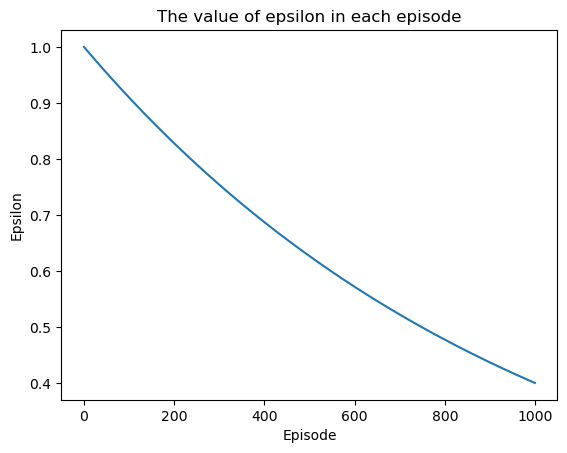

In [85]:
import matplotlib.pyplot as plt

plt.plot(range(N_EPISODES), epsilon_history)
plt.title("The value of epsilon in each episode")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.show()

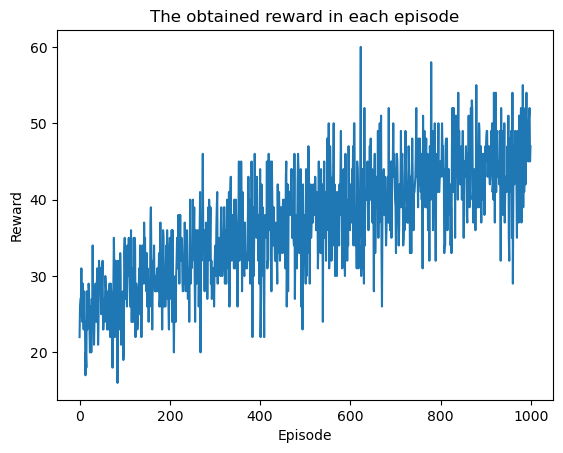

In [86]:
plt.plot(range(N_EPISODES), rewards)
plt.title("The obtained reward in each episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

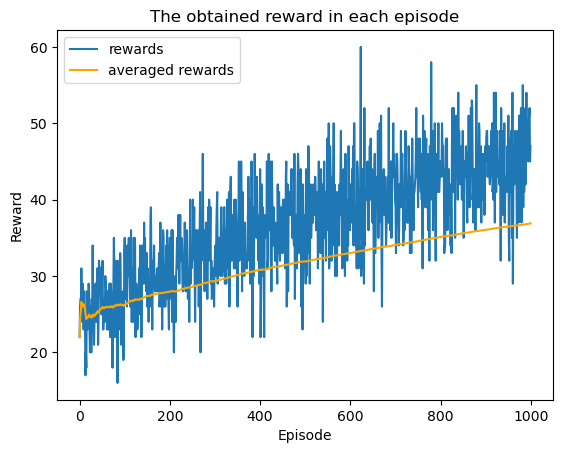

In [87]:
def smoothen(data):
    return np.cumsum(data) / np.arange(len(rewards) + 1)[1:]

rewards_smooth_window_5 = smoothen(rewards)

plt.plot(range(N_EPISODES), rewards)
plt.plot(range(N_EPISODES), rewards_smooth_window_5, color="orange")
plt.title("The obtained reward in each episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend(["rewards", "averaged rewards"])
plt.show()
